# Dashboard

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import os
from os import listdir
from os.path import exists
import pickle
import json
from datetime import datetime
import timeit
import nltk
import urllib
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter, defaultdict
from nltk.tokenize import RegexpTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Phrases
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string
from gensim.corpora import Dictionary
from gensim.models import LdaModel, Word2Vec
from gensim.models.coherencemodel import CoherenceModel
from gensim import utils
import dask.dataframe as dd
from dask.distributed import Client
import pyLDAvis
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn import preprocessing
from sklearn.manifold import TSNE
from textblob import TextBlob
import itertools
from IPython.core.display import HTML
from sklearn import preprocessing, cluster, metrics, manifold, decomposition
from matplotlib.image import imread
import cv2
import time
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import warnings
warnings.filterwarnings('ignore')

In [3]:
plt.style.use("dark_background")
pd.set_option("max_rows", None)
pd.set_option("max_columns", None)
pio.renderers.default='notebook'

In [11]:
path = "./data/"
sav_path = "./sav/"
photo_desc_filename = "photos.json"
path_to_photo_desc = path + photo_desc_filename
path_to_photos = path + "photos/"
FILENAME_REVIEWS = "data/yelp_academic_dataset_review.json"
dash_prefix = "DASH_"

## Détection des sujets d’insatisfaction présents dans les commentaires postés sur la plateforme

In [4]:
def import_and_sample_bad_reviews(
    path, 
    nb_sample, 
    plot=False, 
    verbose=False,
    random_state=1
):
    path = "./{}".format(path)
    if verbose: 
        print("Importation des reviews depuis {}".format(path))
    reviews = pd.read_json(path, lines=True)
    if verbose:
        print("{} reviews importées".format(reviews.shape[0]))
    if plot:
        plt.figure(figsize=(18,9))
        ax = sns.countplot(
            data = reviews,
            x = "stars"
        )
        ax.bar_label(ax.containers[0])
        ax.set_title("répartition des reviews par note (avant échantillonage)")
        plt.show()
    if verbose:
        print("Récupération des reviews dont la note est inférieure à 3 étoiles...")
    reviews = reviews[reviews["stars"] < 3]
    if verbose:
        print("{} mauvaises reviews récupérées")
        print("Echantillonage de {} reviews...".format(nb_sample))
    reviews = reviews.sample(n=nb_sample, random_state=random_state)
    if verbose:
        display(reviews.head())
        print("Echantillonage OK. Nombre de reviews : {}".format(reviews.shape[0]))
    if plot:
        plt.figure(figsize=(18,9))
        ax = sns.countplot(
            data = reviews,
            x = "stars"
        )
        ax.bar_label(ax.containers[0])
        ax.set_title("répartition des reviews par note (après échantillonage)")
        plt.show()
    return reviews

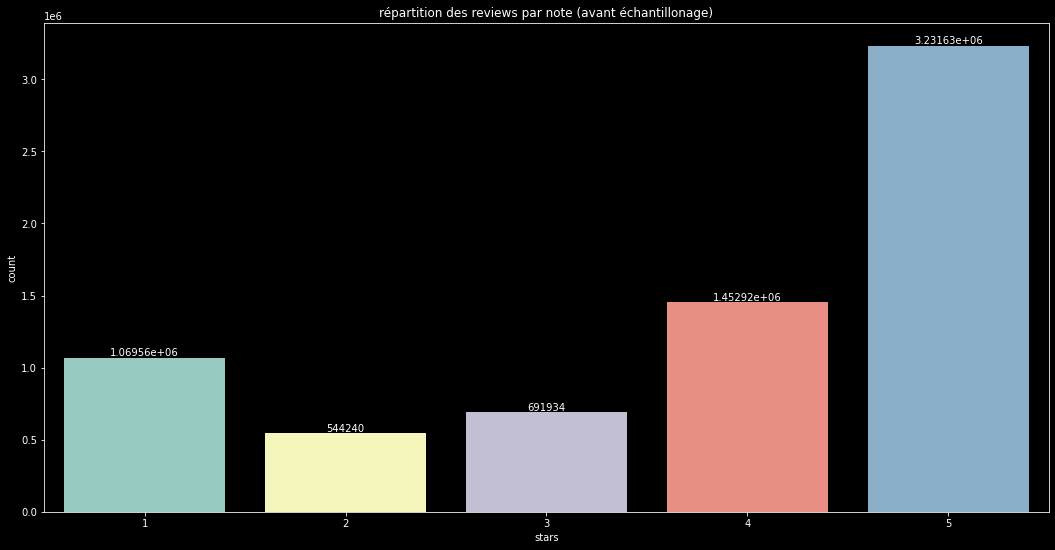

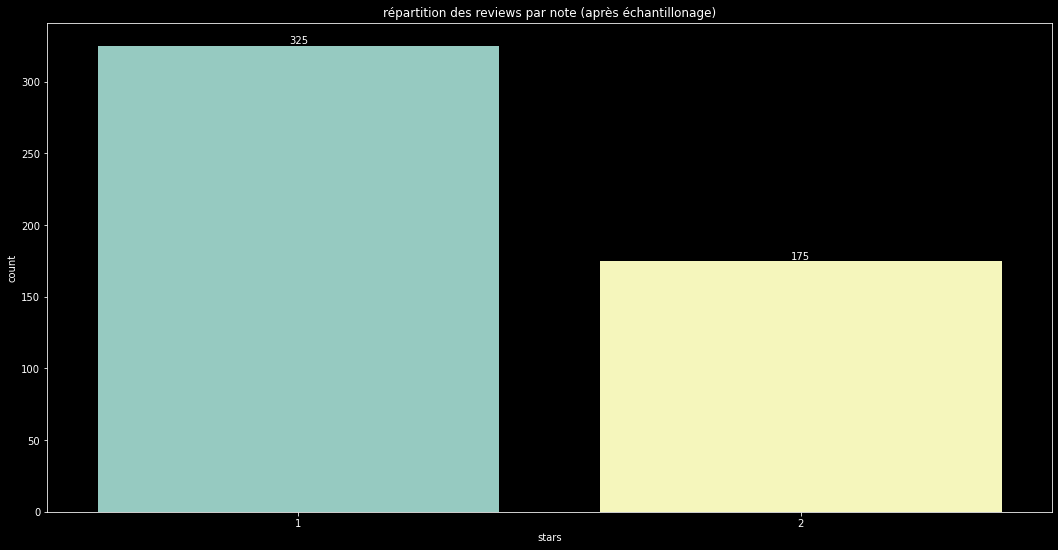

In [7]:
reviews = import_and_sample_bad_reviews(
    FILENAME_REVIEWS, 
    500, 
    plot=True, 
    verbose=False,
    random_state=1
)

In [8]:
del reviews

In [73]:
bow_corpus = pickle.load(open(sav_path+dash_prefix+"bow_corpus", "rb"))
tfidf_corpus = pickle.load(open(sav_path+dash_prefix+"tfidf_corpus", "rb"))
coherence_score = pickle.load(open(sav_path+dash_prefix+"coherence_score", "rb"))
coherence_scores = pickle.load(open(sav_path+dash_prefix+"coherence_scores", "rb"))
coherence_scores_bow = pickle.load(open(sav_path+dash_prefix+"coherence_scores_bow", "rb"))
coherence_score_bow = pickle.load(open(sav_path+dash_prefix+"coherence_score_bow", "rb"))
coherence_scores_tfidf = pickle.load(open(sav_path+dash_prefix+"coherence_scores_tfidf", "rb"))
coherence_score_tfidf = pickle.load(open(sav_path+dash_prefix+"coherence_score_tfidf", "rb"))
corpus = pickle.load(open(sav_path+dash_prefix+"corpus", "rb"))
dictionary = pickle.load(open(sav_path+dash_prefix+"dictionary", "rb"))
lda = pickle.load(open(sav_path+dash_prefix+"lda", "rb"))
lda_bow = pickle.load(open(sav_path+dash_prefix+"lda_bow", "rb"))
lda_tfidf = pickle.load(open(sav_path+dash_prefix+"lda_tfidf", "rb"))
perplexity_score = pickle.load(open(sav_path+dash_prefix+"perplexity_score", "rb"))
perplexity_scores = pickle.load(open(sav_path+dash_prefix+"perplexity_scores", "rb"))
perplexity_scores_bow = pickle.load(open(sav_path+dash_prefix+"perplexity_scores_bow", "rb"))
perplexity_score_bow = pickle.load(open(sav_path+dash_prefix+"perplexity_score_bow", "rb"))
perplexity_scores_tfidf = pickle.load(open(sav_path+dash_prefix+"perplexity_scores_tfidf", "rb"))
perplexity_score_tfidf = pickle.load(open(sav_path+dash_prefix+"perplexity_score_tfidf", "rb"))
reviews = pickle.load(open(sav_path+dash_prefix+"reviews", "rb"))
sentences = pickle.load(open(sav_path+dash_prefix+"sentences", "rb"))
top_topics = pickle.load(open(sav_path+dash_prefix+"top_topics", "rb"))
top_topics_bow = pickle.load(open(sav_path+dash_prefix+"top_topics_bow", "rb"))
top_topics_tfidf = pickle.load(open(sav_path+dash_prefix+"top_topics_tfidf", "rb"))

## LDA

In [61]:
def topics_wordclouds(model):
    for topic in range(model.num_topics):
        plt.figure(figsize=(10, 10))
        wc = WordCloud().fit_words(dict(model.show_topic(topic, 200)))
        plt.imshow(wc)
        plt.axis("off")
        plt.title("Sujet d'insatisfaction n°{}".format(str(topic+1)))
        plt.show()
    return

def get_perplexity_score(model, corpus):
    perplexity_score = model.log_perplexity(corpus)
    return perplexity_score

def get_coherence_score(model, reviews, dictionary):
    ls_reviews = reviews["text"].tolist()
    coherence = CoherenceModel(
        model=model, 
        texts=ls_reviews, 
        dictionary=dictionary, 
        coherence='c_v'
    )
    coherence_score = coherence.get_coherence()
    return coherence_score

## LDA avec corpus BOW

### détermination du nombre optimal de topics

[Text(0.5, 1.0, 'Scores de perplexité en fonction du nombre de topics')]

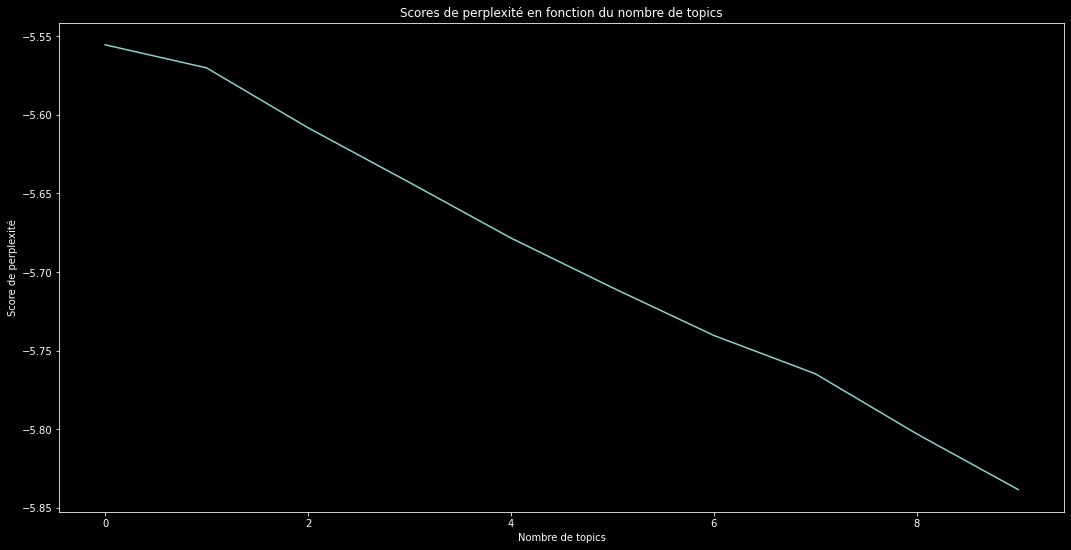

In [27]:
plt.figure(figsize=(18,9))
nb_topics_bow = list(range(len(perplexity_scores_bow)))
max_perplexity_bow=max(perplexity_scores_bow)
idx_max_perplexity_bow = perplexity_scores_bow.index(max_perplexity_bow)
plt.xlabel("Nombre de topics")
plt.ylabel("Score de perplexité")
sns.lineplot(
    x=nb_topics_bow,
    y=perplexity_scores_bow
).set(title="Scores de perplexité en fonction du nombre de topics")

Text(3, 0.28251525823485607, 'max coherence : 0.28251525823485607 pour 3 topics')

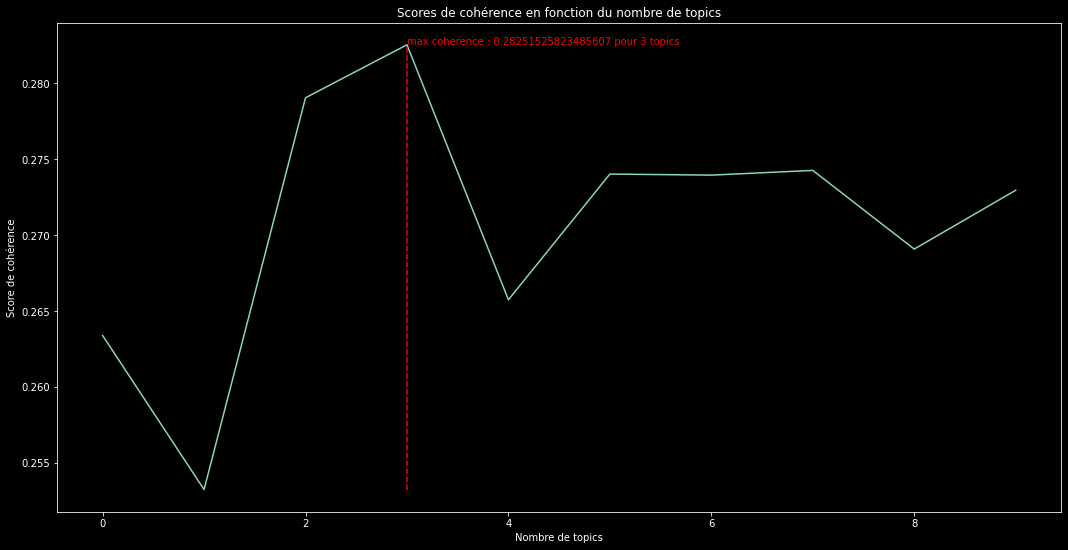

In [28]:
plt.figure(figsize=(18,9))
nb_topics_bow = list(range(len(coherence_scores_bow)))
max_coherence_bow=max(coherence_scores_bow)
idx_max_coherence_bow = coherence_scores_bow.index(max_coherence_bow)
plt.xlabel("Nombre de topics")
plt.ylabel("Score de cohérence")
sns.lineplot(
    x=nb_topics_bow,
    y=coherence_scores_bow
).set(title="Scores de cohérence en fonction du nombre de topics")
plt.vlines(
    idx_max_coherence_bow,
    ymin=min(coherence_scores_bow),
    ymax=max_coherence_bow,
    color="#FF0000",
    linestyle="dashed"
)
plt.text(
    idx_max_coherence_bow,
    max_coherence_bow,
    "max coherence : {} pour {} topics".format(
        max_coherence_bow, 
        idx_max_coherence_bow
    ),
    color="#FF0000"
)

In [29]:
top_topics_bow = lda_bow.top_topics(bow_corpus)
average_coherence = sum([topic[1] for topic in top_topics])/num_topics
print("Cohérence moyenne de la thématique : {}".format(average_coherence))

Cohérence moyenne de la thématique : -1.4563285974132427


### Wordclouds

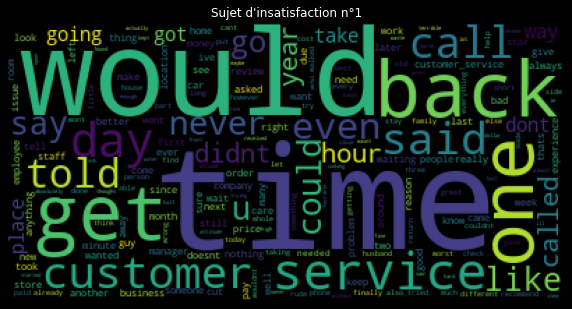

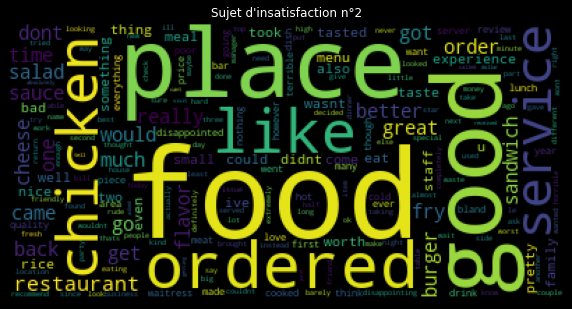

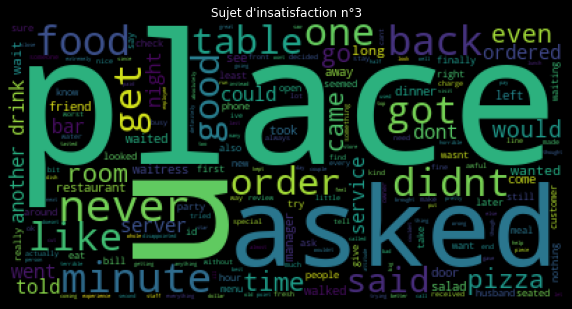

In [30]:
topics_wordclouds(lda_bow)

### PyLDAvis

In [31]:
pyLDAvis.enable_notebook()
p_bow = pyLDAvis.gensim_models.prepare(lda_bow, bow_corpus, dictionary)
p_bow

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.086063 -0.030345       1        1  41.036182
1      0.090419 -0.026161       2        1  31.448679
2     -0.004356  0.056505       3        1  27.515139, topic_info=                 Term        Freq       Total Category  logprob  loglift
4                food  266.000000  266.000000  Default  30.0000  30.0000
229           chicken   78.000000   78.000000  Default  29.0000  29.0000
117           ordered  144.000000  144.000000  Default  28.0000  28.0000
269             table   71.000000   71.000000  Default  27.0000  27.0000
164             pizza   50.000000   50.000000  Default  26.0000  26.0000
122             asked  121.000000  121.000000  Default  25.0000  25.0000
123            burger   41.000000   41.000000  Default  24.0000  24.0000
133               fry   45.000000   45.000000  Default  23.0000  23.0000
124            cheese   49.000000   49.000000  Default  22.0000  22.0000
102              said  131.000000  131.000000  Default  21.0000  21.0000
38              place  242.000000  242.000000  Default  20.0000  20.0000
22               good  197.000000  197.000000  Default  19.0000  19.0000
70             minute  116.000000  116.000000  Default  18.0000  18.0000
118          sandwich   41.000000   41.000000  Default  17.0000  17.0000
27         restaurant   92.000000   92.000000  Default  16.0000  16.0000
236             sauce   51.000000   51.000000  Default  15.0000  15.0000
147              call   86.000000   86.000000  Default  14.0000  14.0000
89           customer  100.000000  100.000000  Default  13.0000  13.0000
78             server   62.000000   62.000000  Default  12.0000  12.0000
190            flavor   44.000000   44.000000  Default  11.0000  11.0000
193             salad   66.000000   66.000000  Default  10.0000  10.0000
250              room   68.000000   68.000000  Default   9.0000   9.0000
18              drink   60.000000   60.000000  Default   8.0000   8.0000
90   customer_service   46.000000   46.000000  Default   7.0000   7.0000
72              never  151.000000  151.000000  Default   6.0000   6.0000
272              rice   30.000000   30.000000  Default   5.0000   5.0000
91                day  107.000000  107.000000  Default   4.0000   4.0000
144             taste   32.000000   32.000000  Default   3.0000   3.0000
210            tasted   41.000000   41.000000  Default   2.0000   2.0000
212               car   45.000000   45.000000  Default   1.0000   1.0000
90   customer_service   44.168256   46.460593   Topic1  -4.9611   0.8401
92                due   28.918829   30.640789   Topic1  -5.3846   0.8329
212               car   42.616202   45.486683   Topic1  -4.9969   0.8255
247           company   36.771418   40.498129   Topic1  -5.1444   0.7942
112              week   41.796633   47.446409   Topic1  -5.0163   0.7639
147              call   76.231932   86.976003   Topic1  -4.4154   0.7589
221             month   42.148415   48.385388   Topic1  -5.0079   0.7527
226             store   41.017259   48.418888   Topic1  -5.0351   0.7248
257               guy   41.659870   49.379270   Topic1  -5.0196   0.7207
75            problem   24.809486   29.603844   Topic1  -5.5379   0.7140
89           customer   83.353088  100.787245   Topic1  -4.3260   0.7008
91                day   88.272064  107.599617   Topic1  -4.2687   0.6927
73                pay   36.853309   45.447164   Topic1  -5.1422   0.6811
258              keep   22.326649   27.644390   Topic1  -5.6434   0.6771
88             called   51.407252   65.124674   Topic1  -4.8094   0.6542
2            business   36.561347   47.302593   Topic1  -5.1501   0.6331
237            needed   22.011812   28.583951   Topic1  -5.6576   0.6294
59            already   21.027293   27.608491   Topic1  -5.7033   0.6184
213              care   31.898671   42.420555   Topic1  -5.2866   0.6056
248          employee   32.576207   4

### Sujets d'insatisfaction

In [32]:
for idx, topic in lda_bow.print_topics(num_topics=-1, num_words=8):
    print("Topic: {}".format(idx, topic))
    print("Mots : {}".format(topic))

Topic: 0
Mots : 0.023*"time" + 0.019*"would" + 0.019*"back" + 0.018*"get" + 0.017*"one" + 0.017*"service" + 0.014*"day" + 0.013*"customer"
Topic: 1
Mots : 0.041*"food" + 0.023*"place" + 0.023*"good" + 0.020*"ordered" + 0.018*"like" + 0.016*"chicken" + 0.013*"service" + 0.012*"restaurant"
Topic: 2
Mots : 0.020*"place" + 0.019*"u" + 0.017*"asked" + 0.017*"never" + 0.016*"minute" + 0.015*"back" + 0.015*"food" + 0.014*"got"


### Score de perplexité

In [33]:
perplexity_score_bow = get_perplexity_score(lda_bow, bow_corpus)
print("Score de perplexité : {}".format(round(perplexity_score_bow, 3)))

Score de perplexité : -5.411


### Score de cohérence

In [75]:
print("Score de cohérence : {}".format(round(coherence_score_bow, 3)))

Score de cohérence : 0.267


## LDA avec corpus TF-IDF

### détermination du nombre optimal de topics

[Text(0.5, 1.0, 'Scores de perplexité en fonction du nombre de topics')]

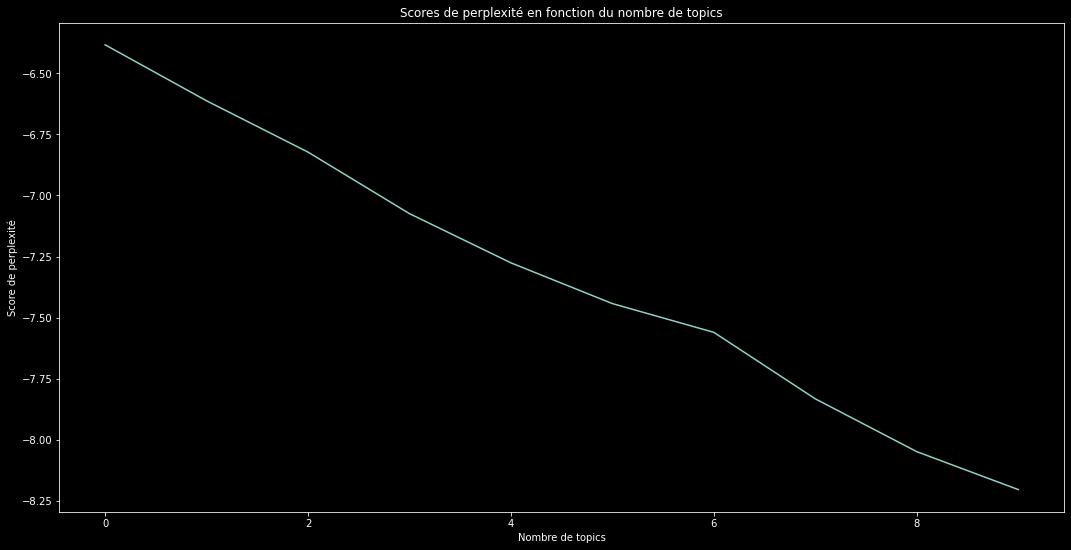

In [65]:
plt.figure(figsize=(18,9))
nb_topics_tfidf = list(range(len(perplexity_scores_tfidf)))
max_perplexity_tfidf=max(perplexity_scores_tfidf)
idx_max_perplexity_tfidf = perplexity_scores_tfidf.index(max_perplexity_tfidf)
plt.xlabel("Nombre de topics")
plt.ylabel("Score de perplexité")
sns.lineplot(
    x=nb_topics_tfidf,
    y=perplexity_scores_tfidf
).set(title="Scores de perplexité en fonction du nombre de topics")

Text(1, 0.2885518465291566, 'max coherence : 0.2885518465291566 pour 1 topics')

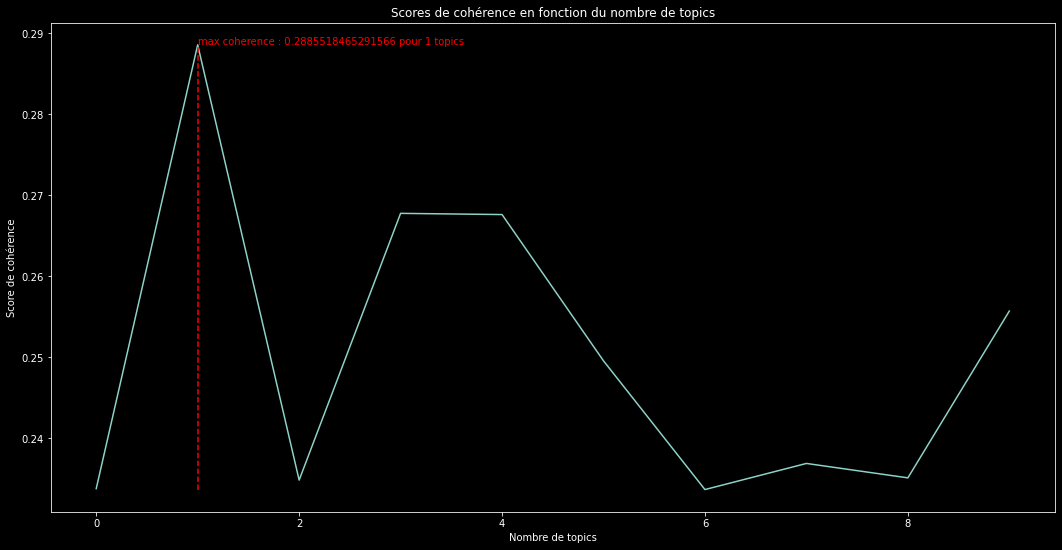

In [66]:
plt.figure(figsize=(18,9))
nb_topics_tfidf = list(range(len(coherence_scores_tfidf)))
max_coherence_tfidf=max(coherence_scores_tfidf)
idx_max_coherence_tfidf = coherence_scores_tfidf.index(max_coherence_tfidf)
plt.xlabel("Nombre de topics")
plt.ylabel("Score de cohérence")
sns.lineplot(
    x=nb_topics_tfidf,
    y=coherence_scores_tfidf
).set(title="Scores de cohérence en fonction du nombre de topics")
plt.vlines(
    idx_max_coherence_tfidf,
    ymin=min(coherence_scores_tfidf),
    ymax=max_coherence_tfidf,
    color="#FF0000",
    linestyle="dashed"
)
plt.text(
    idx_max_coherence_tfidf,
    max_coherence_tfidf,
    "max coherence : {} pour {} topics".format(
        max_coherence_tfidf, 
        idx_max_coherence_tfidf
    ),
    color="#FF0000"
)

In [67]:
top_topics_tfidf = lda_tfidf.top_topics(tfidf_corpus)
average_coherence = sum([topic[1] for topic in top_topics_tfidf])/num_topics
print("Cohérence moyenne de la thématique : {}".format(average_coherence))

Cohérence moyenne de la thématique : -2.1110470367441425


### Wordclouds

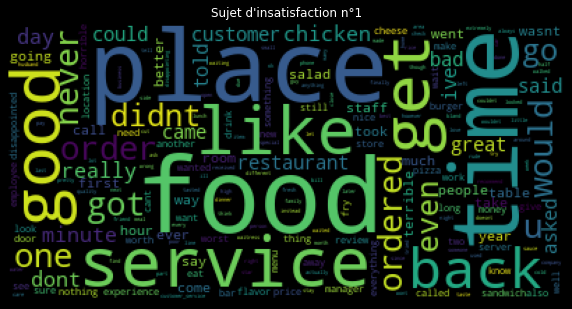

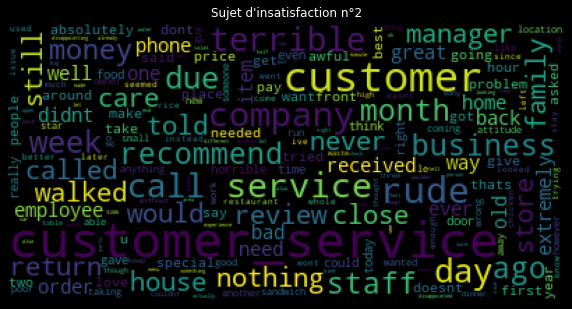

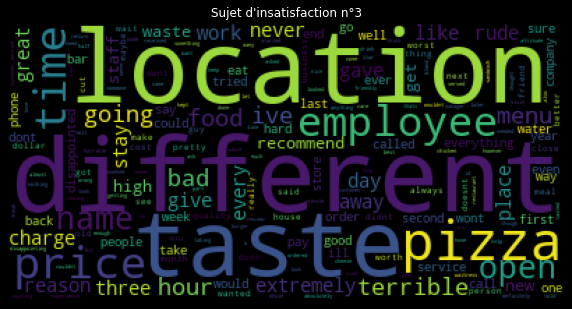

In [68]:
topics_wordclouds(lda_tfidf)

### PyLDAvis

In [69]:
pyLDAvis.enable_notebook()
p_tfidf = pyLDAvis.gensim_models.prepare(lda_tfidf, tfidf_corpus, dictionary)
p_tfidf

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.011706 -0.000669       1        1  96.661047
1     -0.007475 -0.003288       2        1   2.097821
2     -0.004231  0.003958       3        1   1.241132, topic_info=                 Term       Freq      Total Category  logprob  loglift
89           customer  12.000000  12.000000  Default  30.0000  30.0000
12            service  17.000000  17.000000  Default  29.0000  29.0000
90   customer_service   8.000000   8.000000  Default  28.0000  28.0000
91                day  11.000000  11.000000  Default  27.0000  27.0000
147              call  10.000000  10.000000  Default  26.0000  26.0000
107          terrible   9.000000   9.000000  Default  25.0000  25.0000
14              would  14.000000  14.000000  Default  24.0000  24.0000
72              never  14.000000  14.000000  Default  23.0000  23.0000
38              place  18.000000  18.000000  Default  22.0000  22.0000
56               time  17.000000  17.000000  Default  21.0000  21.0000
232              rude   7.000000   7.000000  Default  20.0000  20.0000
4                food  20.000000  20.000000  Default  19.0000  19.0000
96                get  16.000000  16.000000  Default  18.0000  18.0000
165             staff   9.000000   9.000000  Default  17.0000  17.0000
167             order  14.000000  14.000000  Default  16.0000  16.0000
61               back  15.000000  15.000000  Default  15.0000  15.0000
37                one  14.000000  14.000000  Default  14.0000  14.0000
6                like  15.000000  15.000000  Default  13.0000  13.0000
128             didnt  13.000000  13.000000  Default  12.0000  12.0000
22               good  16.000000  16.000000  Default  11.0000  11.0000
247           company   7.000000   7.000000  Default  10.0000  10.0000
98                got  14.000000  14.000000  Default   9.0000   9.0000
234               bad  11.000000  11.000000  Default   8.0000   8.0000
83                  u  14.000000  14.000000  Default   7.0000   7.0000
5               great  11.000000  11.000000  Default   6.0000   6.0000
39               even  12.000000  12.000000  Default   5.0000   5.0000
68               dont  12.000000  12.000000  Default   4.0000   4.0000
150                go  12.000000  12.000000  Default   3.0000   3.0000
109              told  10.000000  10.000000  Default   2.0000   2.0000
117           ordered  14.000000  14.000000  Default   1.0000   1.0000
4                food  20.365072  20.612823   Topic1  -4.5842   0.0219
38              place  18.674165  18.931934   Topic1  -4.6708   0.0203
22               good  16.272441  16.511896   Topic1  -4.8085   0.0194
56               time  16.812767  17.065195   Topic1  -4.7758   0.0191
6                like  15.633755  15.878195   Topic1  -4.8485   0.0184
117           ordered  14.579950  14.810754   Topic1  -4.9183   0.0183
96                get  16.157874  16.414680   Topic1  -4.8156   0.0182
61               back  14.933395  15.191196   Topic1  -4.8944   0.0168
37                one  14.675437  14.934757   Topic1  -4.9118   0.0164
167             order  14.681451  14.942222   Topic1  -4.9114   0.0164
83                  u  13.839224  14.085854   Topic1  -4.9705   0.0163
98                got  13.807962  14.055495   Topic1  -4.9727   0.0162
70             minute  12.199030  12.427433   Topic1  -5.0966   0.0154
150                go  12.710122  12.950652   Topic1  -5.0556   0.0152
39               even  12.698076  12.942168   Topic1  -5.0565   0.0149
128             didnt  13.266676  13.525251   Topic1  -5.0127   0.0147
24             really  12.286260  12.529296   Topic1  -5.0895   0.0144
229           chicken  11.581876  11.814431   Topic1  -5.1485   0.0141
14              would  14.640962  14.936599   Topic1  -4.9141   0.0140
72              never  14.066644  14.352681   Topic1  -4.9542   0.0138
68               dont  11.979144  12.226853   Topic1  -5.1148   0.

### Sujets d'insatisfaction

In [70]:
for idx, topic in lda_tfidf.print_topics(num_topics=-1, num_words=8):
    print("Topic: {}".format(idx, topic))
    print("Mots : {}".format(topic))

Topic: 0
Mots : 0.010*"food" + 0.009*"place" + 0.008*"time" + 0.008*"service" + 0.008*"good" + 0.008*"get" + 0.008*"like" + 0.007*"back"
Topic: 1
Mots : 0.017*"customer_service" + 0.012*"customer" + 0.009*"rude" + 0.008*"company" + 0.008*"service" + 0.007*"call" + 0.007*"terrible" + 0.007*"day"
Topic: 2
Mots : 0.004*"different" + 0.004*"location" + 0.004*"taste" + 0.004*"pizza" + 0.004*"price" + 0.004*"time" + 0.004*"employee" + 0.004*"open"


### Score de perplexité

In [71]:
perplexity_score_tfidf = get_perplexity_score(lda_tfidf, tfidf_corpus)
print("Score de perplexité : {}".format(round(perplexity_score_tfidf, 3)))

Score de perplexité : -5.823


### Score de cohérence

In [74]:
print("Score de cohérence : {}".format(round(coherence_score_tfidf, 3)))

Score de cohérence : 0.265


## Analyse de sentiments

In [35]:
def get_polarity(text):
   return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [36]:
reviews["polarity"] = reviews["text"].map(get_polarity)
reviews["subjectivity"] = reviews["text"].map(get_subjectivity)
fig = px.scatter(
    reviews, 
    y="subjectivity", 
    x="polarity", 
    hover_data=['text'],
    color="stars",
    template="plotly_dark",
    color_continuous_scale="turbo",
    title="Analyse de sentiment des reviews"
)
fig.show()

# photos

In [59]:
df_photo = pickle.load(open(sav_path+dash_prefix+"df_photo", "rb"))
df_tsne = pickle.load(open(sav_path+dash_prefix+"df_tsne", "rb"))
new_confusion_matrix = pickle.load(open(sav_path+dash_prefix+"new_confusion_matrix", "rb"))
cls = pickle.load(open(sav_path+dash_prefix+"cls", "rb"))
ari_score_1 = pickle.load(open(sav_path+dash_prefix+"ari_score_1", "rb"))
score_ari_cnn = pickle.load(open(sav_path+dash_prefix+"score_ari_cnn", "rb"))

In [37]:
def import_photos_desc(path_to_json, verbose=False):
    df_photos_desc = pd.read_json(
        (path_to_json),
        lines=True
    )
    if verbose:
        print("Les descriptions des photos ont été importées.")
        print("Nous avons la description de {} photos".format(df_photos_desc.shape[0]))
    return df_photos_desc

def import_photos(path):
    ls_photos = [f for f in listdir(path)]
    print("{} photos importées".format(len(ls_photos)))
    return ls_photos

def photo_preview(df, nb_by_cat=3):
    ls_lbls = df["label"].unique().tolist()
    df_preview = df.groupby("label").head(nb_by_cat).sort_values(by="label").reset_index(drop=True)
    for lbl in ls_lbls:
        df_cat = df_preview[df_preview["label"]==lbl].reset_index(drop=True)
        fig, ax = plt.subplots(ncols=nb_by_cat)
        fig.tight_layout()
        plt.title("Apperçu de la catégorie {}".format(lbl), y=1.5)
        for i in range(nb_by_cat):
            plt.subplot(130 + 1 + i)
            filepath = df_cat.iloc[i]["image"]
            pic = cv2.imread(filepath)
            plt.imshow(pic)
        plt.show()

def import_and_sample(
    path_to_photo_desc,
    path_to_photo,
    sample=None,
    verbose=False,
    plot=False,
    preview=False
):
    if verbose:
        display(HTML("<h1>Importation des photos</h1>"))
    # importation de la description des photos
    df_photos_desc = import_photos_desc(
        path_to_photo_desc, 
        verbose=verbose
    )
    ls_labels = df_photos_desc["label"].unique().tolist()
    if verbose:
        print("Apperçu :")
        display(df_photos_desc.head())
        display(HTML("<h2>Répartition des labels</h2>"))
        print("Il y a {} labels différents, qui sont :".format(len(ls_labels)))
        for label in ls_labels:
            print(label)
        print("Voici la répartition des labels :")
        df_photos_desc["label"].value_counts()
    if plot:
        df_photos_desc["label"].value_counts().plot(
            kind="pie",
            figsize=(10,10),
            autopct="%1.1f%%",
            title="Répartition des catégories de photos"
        )
        plt.show()
    # echantillonage
    if sample is not None:
        display(HTML("<h1>Echantillonage</h1>"))
        print("Echantillonage de {} descriptions pour chacun des {} labels".format(sample,len(ls_labels)))
        df_photos_desc = df_photos_desc.groupby("label").head(sample).reset_index(drop=True)
        if verbose:
            print("L'échantillon comporte {} lignes".format(df_photos_desc.shape[0]))
            print("Soit, par catégorie :")
            print(df_photos_desc["label"].value_counts())
        if plot:
            df_photos_desc["label"].value_counts().plot(
                kind="pie",
                figsize=(10,10),
                autopct="%1.1f%%",
                title="Répartition des catégories de photos de l'échantillon"
            )
            plt.show()
    # chargement des photos
    ls_photos = import_photos(path_to_photo)
    ls_photos_smpl = [f for f in listdir(path_to_photos) and df_photos_desc["photo_id"]]
    df_photos_desc["image"] = ls_photos_smpl
    df_photos_desc["image"]  = path_to_photo + df_photos_desc["image"] + ".jpg"
    if preview:
        display(HTML("<h1>Preview des photos par catégorie</h1>"))
        photo_preview(df_photos_desc, nb_by_cat=3)
    return df_photos_desc

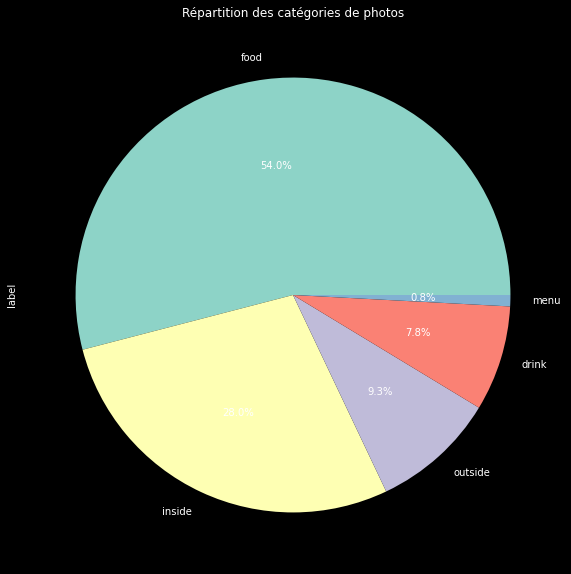

Echantillonage de 100 descriptions pour chacun des 5 labels


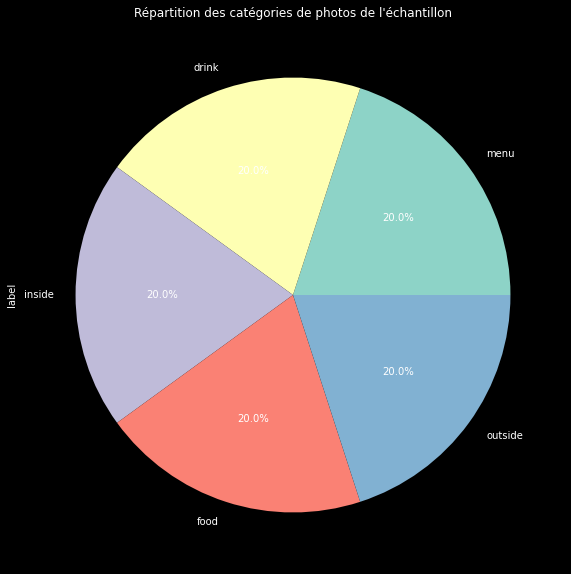

200098 photos importées


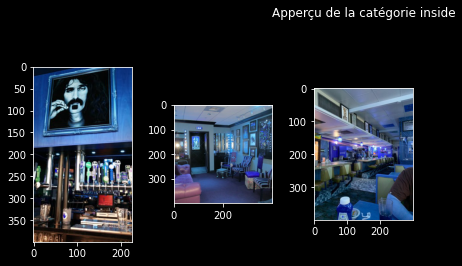

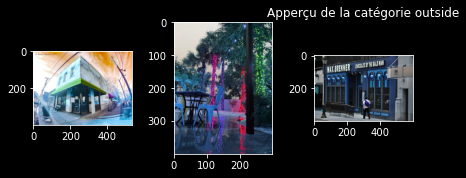

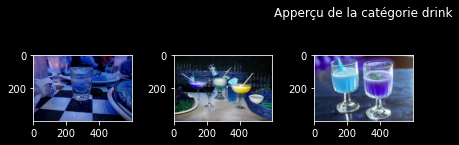

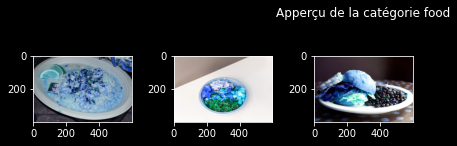

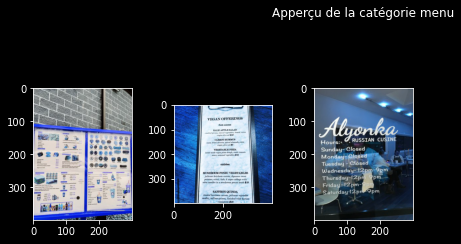

In [38]:
df_photo = import_and_sample(
    path_to_photo_desc,
    path_to_photos,
    sample=100,
    verbose=False,
    plot=True,
    preview=True
)

## Descripteurs SIFT

In [42]:
def process_sift(impath):
    sift = cv2.xfeatures2d.SIFT_create()
    image = cv2.imread(impath)
    # conversion en nuances de gris
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # égalisation de l'histogramme des images
    image = cv2.equalizeHist(image)
    # détection
    kp, des = sift.detectAndCompute(image, None)
    img = cv2.drawKeypoints(image, kp, image)
    return [kp, des, img]

def sift_previews(df, nb_by_cat=3):
    ls_lbls = df["label"].unique().tolist()
    df_preview = df.groupby("label").head(nb_by_cat).sort_values(by="label")
    df_preview = df_preview.reset_index(drop=True)
    for lbl in ls_lbls:
        df_cat = df_preview[df_preview["label"]==lbl].reset_index(drop=True)
        fig, ax = plt.subplots(ncols=nb_by_cat)
        fig.tight_layout()
        plt.title("Apperçu de la catégorie {}".format(lbl), y=1.5)
        for i in range(nb_by_cat):
            plt.subplot(130 + 1 + i)
            filepath = df_cat.iloc[i]["image"]
            kp, des, img = process_sift(filepath)
            img = cv2.drawKeypoints(img, kp, img)
            plt.imshow(img)
        plt.show()
    return

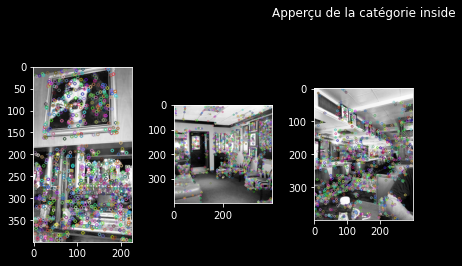

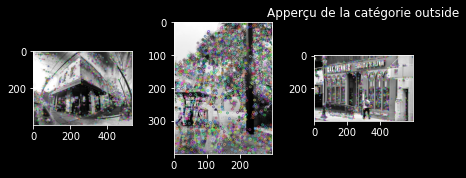

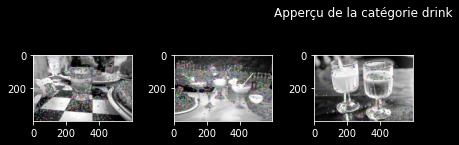

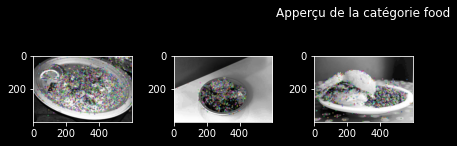

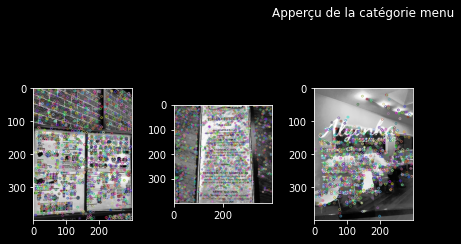

In [43]:
sift_previews(df_photo)

## T-SNE

In [53]:
def plot_tsne(df_photo, df_tsne, hue, title=None):
    n_colors = len(df_photo["label"].unique().tolist())
    if title==None:
        title='TSNE selon les vrais labels'

    plt.figure(figsize=(8,5))
    sns.scatterplot(
        x="tsne1", 
        y="tsne2", 
        hue=hue, 
        data=df_tsne, 
        legend="brief",
        palette=sns.color_palette('tab10', n_colors=n_colors), 
        s=50, 
        alpha=0.6
    )

    plt.title(
        title, 
        fontsize = 30, 
        pad = 35, 
        fontweight = 'bold'
    )
    plt.xlabel(
        'tsne1', 
        fontsize = 26, 
        fontweight = 'bold'
    )
    plt.ylabel(
        'tsne2', 
        fontsize = 26, 
        fontweight = 'bold'
    )
    plt.legend(prop={'size': 14}) 

    plt.show()

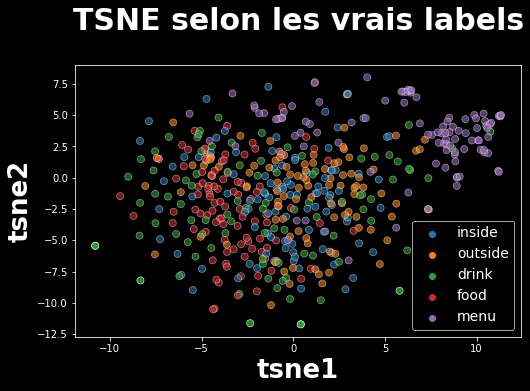

In [46]:
plot_tsne(df_photo, df_tsne, "class")

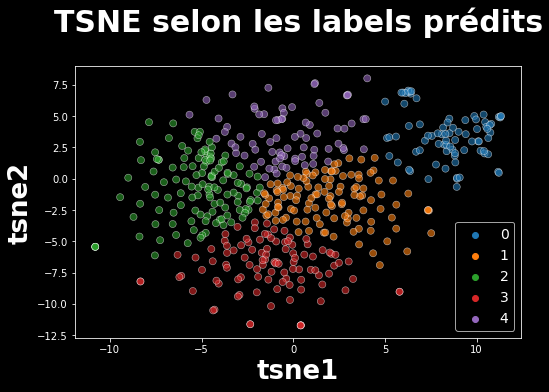

In [54]:
plot_tsne(df_photo, df_tsne, "cluster", "TSNE selon les labels prédits")

In [48]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('Vrai label')
    plt.xlabel('Label prédit \nprécision = {:0.4f}; mal classé = {:0.4f}'.format(accuracy, misclass))
    plt.show()

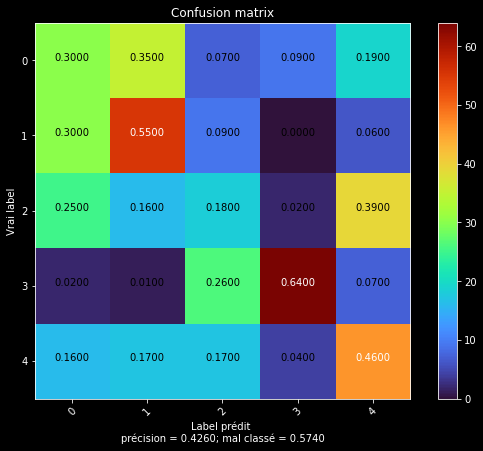

In [50]:
plot_confusion_matrix(new_confusion_matrix, [0, 1, 2, 3, 4], cmap="turbo")

In [60]:
print("score ARI : {}".format(ari_score_1))

score ARI : 0.16138764534786712


## Transfer Learning avec un CNN (VGG16)

![](./sav/tsne_vrais_labels.png)

![](./sav/tsne_labels_predits.png)

In [56]:
print("Score ARI - Transfer Learning = {}".format(score_ari_cnn))

Score ARI - Transfer Learning = 0.16138764534786712
